# Conformal Prediction for 2D Function Fitting

This notebook demonstrates **uncertainty quantification** with spatially varying noise using the `local-cp` package.

## What You'll Learn

1. **Conformal Prediction (CP)**: Prediction intervals with coverage guarantees
2. **Adaptive CP (Local CP)**: Intervals that adapt to local complexity
3. **Evaluation**: Coverage calibration on global and local (noisy) regions

## Key Concept

Conformal Prediction gives **prediction intervals** [lower, upper] where:
- True value falls within interval with probability ≥ 1-α
- **No assumptions** about data distribution
- **Finite-sample** guarantees

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.interpolate import griddata

from local_cp import CP, AdaptiveCP
from local_cp.metrics import coverage, sharpness
from local_cp.batch_eval import cp_test_uncertainties, adaptive_cp_test_uncertainties_grid

sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 100

torch.set_num_threads(3)

np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)
elif torch.backends.mps.is_available():
    torch.manual_seed(42)
print("✓ Imports successful!")

✓ Imports successful!


## 2D Function with Spatially Varying Noise

We create a complex 2D function with an **irregular noisy region** (elliptical ring shape).

In [9]:
def create_irregular_mask(X, center=(0.0, 0.0), rx=0.6, ry=0.5):
    """Create elliptical ring mask for noisy region."""
    cx, cy = center
    dist = ((X[:, 0] - cx) / rx)**2 + ((X[:, 1] - cy) / ry)**2
    return (dist < 1.0) & (dist > 0.3)  # Ring shape

def generate_2d_data(n_samples=3000, seed=42):
    """Generate 2D function with irregular noisy region."""
    np.random.seed(seed)
    torch.manual_seed(seed)
    
    X = 2 * torch.rand(n_samples, 2) - 1  # [-1, 1]^2
    
    # True function (Allen-Cahn inspired)
    Y = (torch.sin(3 * torch.pi * X[:, 0]) * torch.cos(2 * torch.pi * X[:, 1]) + 
         0.3 * (X[:, 0]**2 + X[:, 1]**2)).unsqueeze(-1)
    
    # Irregular noisy region
    noisy_mask = create_irregular_mask(X)
    noise_scale = torch.where(noisy_mask.unsqueeze(-1), 
                               torch.tensor(0.5),   # High noise
                               torch.tensor(0.05))  # Low noise
    
    Y_noisy = Y + noise_scale * torch.randn_like(Y)
    return X, Y_noisy, Y, noisy_mask, noise_scale.squeeze()

# Generate and split data
X_all, Y_all_noisy, Y_all_true, noisy_mask_all, noise_scale_all = generate_2d_data(4000)

n_train, n_cal = 2400, 800
X_train, Y_train = X_all[:n_train], Y_all_noisy[:n_train]
X_cal, Y_cal = X_all[n_train:n_train+n_cal], Y_all_noisy[n_train:n_train+n_cal]
X_test = X_all[n_train+n_cal:]
Y_test = Y_all_noisy[n_train+n_cal:]
Y_test_true = Y_all_true[n_train+n_cal:]
noisy_mask_test = noisy_mask_all[n_train+n_cal:]

print(f"Train: {len(X_train)}, Cal: {len(X_cal)}, Test: {len(X_test)}")
print(f"Noisy region: {noisy_mask_test.sum().item()} points")

Train: 2400, Cal: 800, Test: 800
Noisy region: 129 points


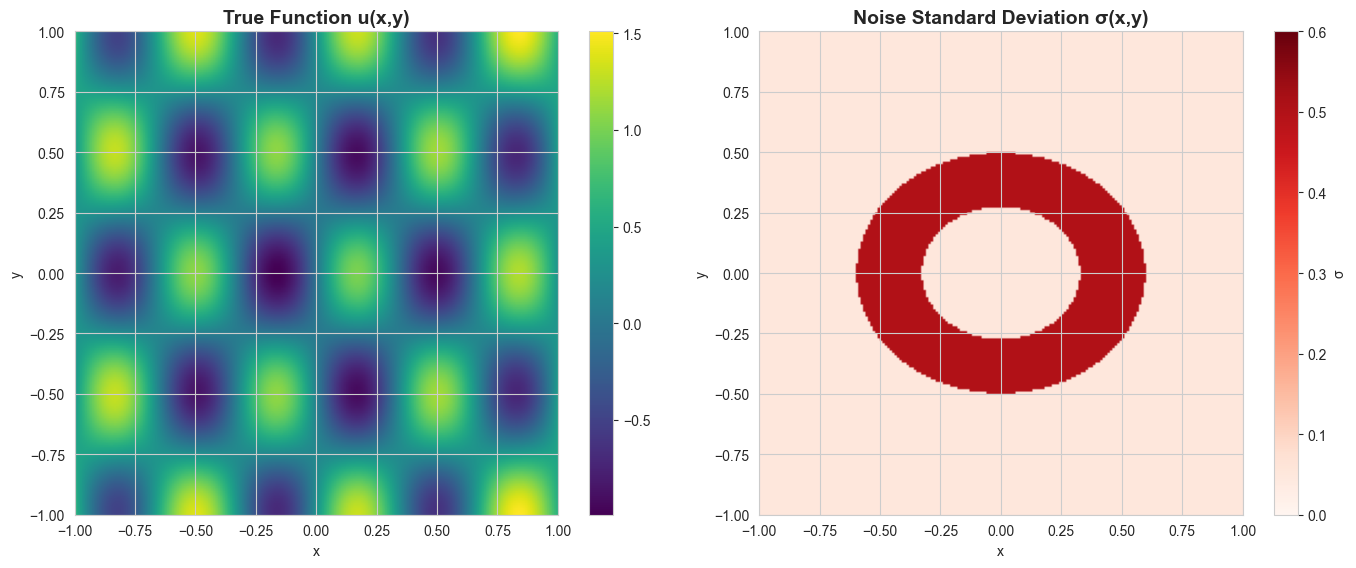

In [10]:
# Create visualization grid
n_grid = 200
x_grid = np.linspace(-1, 1, n_grid)
y_grid = np.linspace(-1, 1, n_grid)
X_mesh, Y_mesh = np.meshgrid(x_grid, y_grid)
grid_points = torch.tensor(np.c_[X_mesh.ravel(), Y_mesh.ravel()], dtype=torch.float32)

# True function on grid
U_true_grid = (torch.sin(3 * torch.pi * grid_points[:, 0]) * 
               torch.cos(2 * torch.pi * grid_points[:, 1]) + 
               0.3 * (grid_points[:, 0]**2 + grid_points[:, 1]**2)).reshape(n_grid, n_grid).numpy()

# Noise level on grid
noisy_mask_grid = create_irregular_mask(grid_points)
noise_grid = torch.where(noisy_mask_grid, torch.tensor(0.5), torch.tensor(0.05)).reshape(n_grid, n_grid).numpy()

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 5.5))

im1 = axes[0].imshow(U_true_grid, extent=[-1, 1, -1, 1], origin='lower', cmap='viridis')
axes[0].set_title('True Function u(x,y)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('x'); axes[0].set_ylabel('y')
plt.colorbar(im1, ax=axes[0])

im2 = axes[1].imshow(noise_grid, extent=[-1, 1, -1, 1], origin='lower', cmap='Reds', vmin=0, vmax=0.6)
axes[1].set_title('Noise Standard Deviation σ(x,y)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('x'); axes[1].set_ylabel('y')
plt.colorbar(im2, ax=axes[1], label='σ')

plt.tight_layout()
plt.show()

## Train Neural Network

In [11]:
class SimpleNN(nn.Module):
    def __init__(self, input_dim=2, hidden_dims=(128, 128, 64), output_dim=1):
        super().__init__()
        layers = []
        prev_dim = input_dim
        for h in hidden_dims:
            layers.extend([nn.Linear(prev_dim, h), nn.Tanh()])
            prev_dim = h
        layers.append(nn.Linear(prev_dim, output_dim))
        self.network = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.network(x)

if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
    
print(f"Device: {device}")

model = SimpleNN(input_dim=2, hidden_dims=(128, 128, 64)).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

X_train_dev, Y_train_dev = X_train.to(device), Y_train.to(device)

model.train()
for epoch in range(2000):
    optimizer.zero_grad()
    loss = criterion(model(X_train_dev), Y_train_dev)
    loss.backward()
    optimizer.step()
    if (epoch + 1) % 400 == 0:
        print(f"Epoch {epoch+1}/2000, Loss: {loss.item():.4f}")

model.eval()
print("✓ Training complete!")

Device: mps
Epoch 400/2000, Loss: 0.2574
Epoch 800/2000, Loss: 0.0754
Epoch 1200/2000, Loss: 0.0486
Epoch 1600/2000, Loss: 0.0454
Epoch 2000/2000, Loss: 0.0445
✓ Training complete!


## Train Dropout Network for UQ

We also train a dropout-based network to estimate uncertainty heuristically.

In [12]:
class DropoutNN(nn.Module):
    def __init__(self, input_dim=2, hidden_dims=(128, 128, 64), output_dim=1, dropout_rate=0.1):
        super().__init__()
        layers = []
        prev_dim = input_dim
        for h in hidden_dims:
            layers.extend([nn.Linear(prev_dim, h), nn.Tanh(), nn.Dropout(dropout_rate)])
            prev_dim = h
        layers.append(nn.Linear(prev_dim, output_dim))
        self.network = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.network(x)

# Train dropout model
dropout_model = DropoutNN(input_dim=2, hidden_dims=(128, 128, 64), dropout_rate=0.1).to(device)
optimizer_dropout = torch.optim.Adam(dropout_model.parameters(), lr=1e-3)

dropout_model.train()
for epoch in range(4000):
    optimizer_dropout.zero_grad()
    loss = criterion(dropout_model(X_train_dev), Y_train_dev)
    loss.backward()
    optimizer_dropout.step()
    if (epoch + 1) % 400 == 0:
        print(f"Epoch {epoch+1}/4000, Loss: {loss.item():.4f}")

print("✓ Dropout network training complete!")

# Compute dropout-based uncertainty
dropout_model.train()  # Keep dropout active
n_samples = 100
X_test_dev = X_test.to(device)

with torch.no_grad():
    predictions = torch.stack([dropout_model(X_test_dev) for _ in range(n_samples)])
    dropout_std = predictions.std(dim=0).cpu().squeeze()

dropout_model.eval()
print(f"Dropout std range: [{dropout_std.min():.3f}, {dropout_std.max():.3f}]")

Epoch 400/4000, Loss: 0.2917
Epoch 800/4000, Loss: 0.2698
Epoch 1200/4000, Loss: 0.1829
Epoch 1600/4000, Loss: 0.1222
Epoch 2000/4000, Loss: 0.1026
Epoch 2400/4000, Loss: 0.0913
Epoch 2800/4000, Loss: 0.0918
Epoch 3200/4000, Loss: 0.0842
Epoch 3600/4000, Loss: 0.0798
Epoch 4000/4000, Loss: 0.0751
✓ Dropout network training complete!
Dropout std range: [0.106, 0.263]


## Apply CP and Adaptive CP

In [13]:
alpha = 0.05  # 95% coverage
k = 30

print("Standard CP...")
cp_model = CP(model, device=device)
lower_cp, upper_cp = cp_model.predict(
    alpha=alpha, X_test=X_test, X_train=X_train, Y_train=Y_train,
    X_cal=X_cal, Y_cal=Y_cal, heuristic='feature', k=k
)

print("\nAdaptive CP (training quantile network)...")
acp_model = AdaptiveCP(
    model, alpha=alpha, device=device, heuristic='feature',
    hidden_layers=(64, 128, 128, 64), epochs=8000,
    step_size=3000, learning_rate=5e-4, gamma=0.7
)
lower_acp, upper_acp = acp_model.predict(
    alpha=alpha, X_test=X_test, X_train=X_train, Y_train=Y_train,
    X_cal=X_cal, Y_cal=Y_cal, k=k, verbose=True
)

print("✓ Complete!")

Standard CP...

Adaptive CP (training quantile network)...
[Adaptive CP] First prediction call - training quantile network...

[Adaptive CP] Training quantile network: 2400 samples, 8000 epochs, tau=0.950
  Epoch 800/8000, Loss: 1.6246e-01, LR: 5.00e-04
  Epoch 1600/8000, Loss: 1.5131e-01, LR: 5.00e-04
  Epoch 2400/8000, Loss: 1.4308e-01, LR: 5.00e-04
  Epoch 3200/8000, Loss: 1.2199e-01, LR: 3.50e-04
  Epoch 4000/8000, Loss: 1.1760e-01, LR: 3.50e-04
  Epoch 4800/8000, Loss: 1.1510e-01, LR: 3.50e-04
  Epoch 5600/8000, Loss: 1.1020e-01, LR: 3.50e-04
  Epoch 6400/8000, Loss: 1.0766e-01, LR: 2.45e-04
  Epoch 7200/8000, Loss: 1.0560e-01, LR: 2.45e-04
  Epoch 8000/8000, Loss: 1.0467e-01, LR: 2.45e-04
[Adaptive CP] Quantile network training complete.

[Adaptive CP] Performing conformal calibration with 800 samples...
[Adaptive CP] Calibration multiplier: c = 1.3412
✓ Complete!


In [14]:
# Compare metrics by region
def eval_region(Y_test, lower, upper, mask, name):
    Y_r, l_r, u_r = Y_test[mask], lower[mask], upper[mask]
    return {
        'Region': name, 'N': mask.sum().item(),
        'Coverage': f"{100*coverage(Y_r, l_r, u_r):.1f}%",
        'Sharpness': f"{sharpness(l_r, u_r):.3f}"
    }

results = []
for name, lower, upper in [('Standard CP', lower_cp, upper_cp), ('Adaptive CP', lower_acp, upper_acp)]:
    results.append(eval_region(Y_test, lower, upper, torch.ones(len(Y_test), dtype=bool), f'{name} - Overall'))
    results.append(eval_region(Y_test, lower, upper, noisy_mask_test, f'{name} - Noisy'))
    results.append(eval_region(Y_test, lower, upper, ~noisy_mask_test, f'{name} - Smooth'))

print("\n" + "="*70)
print(f"Metrics Comparison (α={alpha})")
print("="*70)
print(pd.DataFrame(results).to_string(index=False))
print("\n💡 Adaptive CP adapts interval widths to local noise!")


Metrics Comparison (α=0.05)
               Region   N Coverage Sharpness
Standard CP - Overall 800    96.9%     1.253
  Standard CP - Noisy 129    80.6%     1.204
 Standard CP - Smooth 671   100.0%     1.262
Adaptive CP - Overall 800    95.0%     0.657
  Adaptive CP - Noisy 129    94.6%     2.173
 Adaptive CP - Smooth 671    95.1%     0.365

💡 Adaptive CP adapts interval widths to local noise!


## Visualize Interval Widths

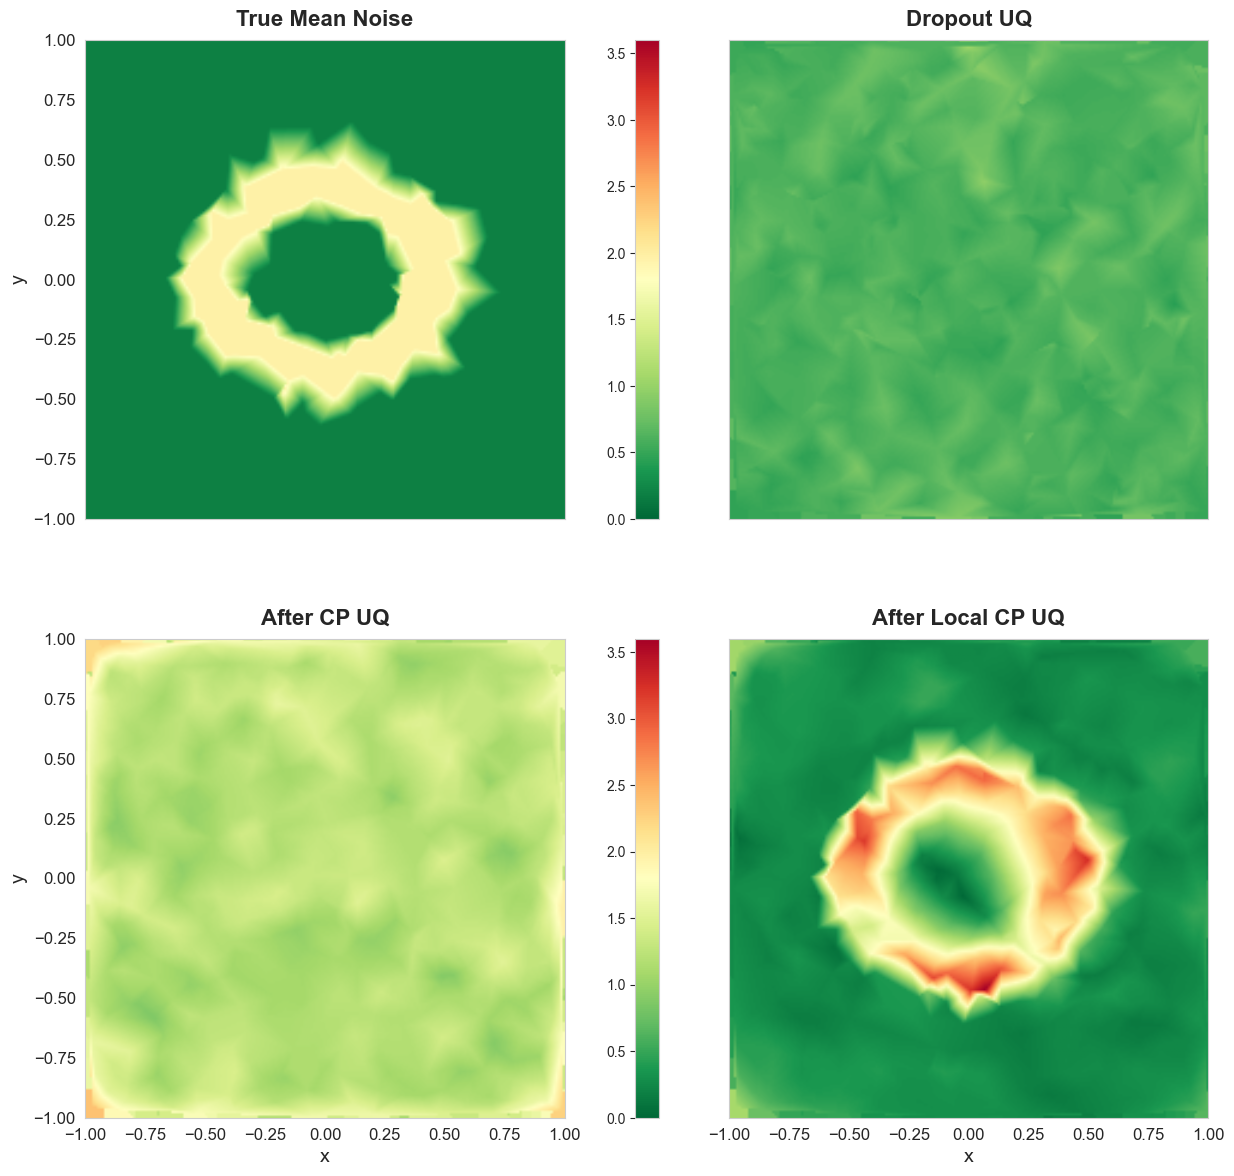

In [15]:
def interpolate_to_grid(X, values, shape=(200, 200)):
    """Interpolate scattered points to grid for smooth visualization."""
    x_g = np.linspace(-1, 1, shape[0])
    y_g = np.linspace(-1, 1, shape[1])
    X_m, Y_m = np.meshgrid(x_g, y_g)
    # Use linear interpolation with fill to ensure all grid points are covered
    Z = griddata(X.cpu().numpy(), values.cpu().numpy().ravel(),
                 (X_m, Y_m), method='linear', fill_value=np.nan)
    # Fill remaining NaN values with nearest neighbor
    if np.isnan(Z).any():
        Z_nearest = griddata(X.cpu().numpy(), values.cpu().numpy().ravel(),
                           (X_m, Y_m), method='nearest')
        Z = np.where(np.isnan(Z), Z_nearest, Z)
    return X_m, Y_m, Z

# Compute widths and mask negative values
width_cp = (upper_cp - lower_cp).squeeze()
width_acp = (upper_acp - lower_acp).squeeze()

# Mask any negative widths
width_cp = torch.clamp(width_cp, min=0.0)
width_acp = torch.clamp(width_acp, min=0.0)

# Get true noise std for test points and compute true interval width
# For normal distribution at α=0.05 (95% confidence): width = 2 * z_{α/2} * σ = 2 * 1.96 * σ
noise_std_test = torch.where(noisy_mask_test, torch.tensor(0.5), torch.tensor(0.05))
true_interval_width = 2 * 1.96 * noise_std_test  # 95% CI width

# Interpolate all quantities
X_m, Y_m, true_width_grid = interpolate_to_grid(X_test, true_interval_width)
_, _, dropout_width_grid = interpolate_to_grid(X_test, 2 * 1.96 * dropout_std)
_, _, w_cp_grid = interpolate_to_grid(X_test, width_cp)
_, _, w_acp_grid = interpolate_to_grid(X_test, width_acp)

# Create professional 2x2 plot with separate colorbars for each row
fig = plt.figure(figsize=(16, 14))

# Create grid spec: 2 rows, each with left plot, colorbar, gap, right plot
# Layout: [left_plot, gap, cbar, gap, right_plot]
gs = fig.add_gridspec(2, 5, 
                      width_ratios=[1.0, 0.02, 0.04, 0.02, 1.0],
                      wspace=0.0, hspace=0.25)

# Row 1 subplots
ax_true = fig.add_subplot(gs[0, 0])
cax1 = fig.add_subplot(gs[0, 2])
ax_dropout = fig.add_subplot(gs[0, 4])

# Row 2 subplots
ax_cp = fig.add_subplot(gs[1, 0])
cax2 = fig.add_subplot(gs[1, 2])
ax_acp = fig.add_subplot(gs[1, 4])

# Set equal aspect for all plots
for ax in (ax_true, ax_dropout, ax_cp, ax_acp):
    ax.set_box_aspect(1)

# Determine global vmin/vmax for all plots (same color range)
all_values = [true_width_grid, dropout_width_grid, w_cp_grid, w_acp_grid]
vmin = 0
vmax = max(np.nanmax(v) for v in all_values)

extent = [-1, 1, -1, 1]
cmap = 'RdYlGn_r'

# Row 1: True interval width and Dropout predicted width
im_true = ax_true.imshow(
    true_width_grid, extent=extent, origin='lower',
    aspect='auto', interpolation='bilinear',
    vmin=vmin, vmax=vmax, cmap=cmap
)
ax_true.set_title('True Mean Noise', fontsize=16, fontweight='bold', pad=10)
ax_true.set_ylabel('y', fontsize=14)
ax_true.tick_params(labelsize=12, bottom=False, labelbottom=False)
ax_true.grid(False)

im_dropout = ax_dropout.imshow(
    dropout_width_grid, extent=extent, origin='lower',
    aspect='auto', interpolation='bilinear',
    vmin=vmin, vmax=vmax, cmap=cmap
)
ax_dropout.set_title('Dropout UQ', fontsize=16, fontweight='bold', pad=10)
ax_dropout.tick_params(labelsize=12, bottom=False, labelbottom=False, 
                       left=False, labelleft=False)
ax_dropout.grid(False)

# Row 2: CP and Adaptive CP interval widths
im_cp = ax_cp.imshow(
    w_cp_grid, extent=extent, origin='lower',
    aspect='auto', interpolation='bilinear',
    vmin=vmin, vmax=vmax, cmap=cmap
)
ax_cp.set_title('After CP UQ', fontsize=16, fontweight='bold', pad=10)
ax_cp.set_xlabel('x', fontsize=14)
ax_cp.set_ylabel('y', fontsize=14)
ax_cp.tick_params(labelsize=12)
ax_cp.grid(False)

im_acp = ax_acp.imshow(
    w_acp_grid, extent=extent, origin='lower',
    aspect='auto', interpolation='bilinear',
    vmin=vmin, vmax=vmax, cmap=cmap
)
ax_acp.set_title('After Local CP UQ', fontsize=16, fontweight='bold', pad=10)
ax_acp.set_xlabel('x', fontsize=14)
ax_acp.tick_params(labelsize=12, left=False, labelleft=False)
ax_acp.grid(False)

# Colorbar for row 1
cbar1 = fig.colorbar(im_true, cax=cax1)
cbar1.ax.tick_params(labelsize=10, pad=3)
cbar1.ax.yaxis.set_ticks_position('left')

# Colorbar for row 2
cbar2 = fig.colorbar(im_cp, cax=cax2)
cbar2.ax.tick_params(labelsize=10, pad=3)
cbar2.ax.yaxis.set_ticks_position('left')

plt.show()

## Grid Evaluation: α ∈ [0.05, 0.95]

Test both methods across multiple α values with **parallel evaluation**.

In [ ]:
alphas_grid = np.arange(0.05, 1.0, 0.05)
print(f"Testing {len(alphas_grid)} α values\n")

print("="*70)
print("GLOBAL EVALUATION (All test points)")
print("="*70)

print("\nStandard CP (parallel)...")
results_cp_global = cp_test_uncertainties(
    cp_model, alphas=alphas_grid, X_train=X_train, Y_train=Y_train,
    X_cal=X_cal, Y_cal=Y_cal, X_test=X_test, Y_test=Y_test,
    heuristic='feature', k=k, parallel=True, show_progress=True
)

print("\nAdaptive CP (parallel, training multiple quantile networks)...")
results_acp_global = adaptive_cp_test_uncertainties_grid(
    model, alphas=alphas_grid, X_train=X_train, Y_train=Y_train,
    X_cal=X_cal, Y_cal=Y_cal, X_test=X_test, Y_test=Y_test,
    heuristic='feature', k=k, hidden_layers=(64, 64, 64),
    epochs=5000, step_size=2000, device=device,
    parallel=True, n_workers=4, show_progress=True
)

print("✓ Global complete!")

Testing 19 α values

GLOBAL EVALUATION (All test points)

Standard CP (parallel)...


Evaluating CP: 100%|██████████| 19/19 [00:00<00:00, 115.79it/s]



Adaptive CP (parallel, training multiple quantile networks)...


Evaluating Adaptive CP:  21%|██        | 4/19 [01:19<04:57, 19.86s/it]


In [ ]:
print("\n" + "="*70)
print("LOCAL EVALUATION (Noisy region only)")
print("="*70)

idx_noisy = torch.nonzero(noisy_mask_test, as_tuple=True)[0].long()

print("\nStandard CP on noisy region...")
results_cp_local = cp_test_uncertainties(
    cp_model, alphas=alphas_grid, X_train=X_train, Y_train=Y_train,
    X_cal=X_cal, Y_cal=Y_cal, X_test=X_test, Y_test=Y_test,
    heuristic='feature', k=k, idx_subset=idx_noisy,
    parallel=True, show_progress=True
)

print("\nAdaptive CP on noisy region...")
results_acp_local = adaptive_cp_test_uncertainties_grid(
    model, alphas=alphas_grid, X_train=X_train, Y_train=Y_train,
    X_cal=X_cal, Y_cal=Y_cal, X_test=X_test, Y_test=Y_test,
    heuristic='feature', k=k, hidden_layers=(64, 64, 64),
    epochs=5000, step_size=2000, device=device, idx_subset=idx_noisy,
    parallel=True, n_workers=4, show_progress=True
)

print("✓ Local complete!")


LOCAL EVALUATION (Noisy region only)

Standard CP on noisy region...


Evaluating CP: 100%|██████████| 19/19 [00:00<00:00, 122.49it/s]



Adaptive CP on noisy region...


Evaluating Adaptive CP: 100%|██████████| 19/19 [02:08<00:00,  6.77s/it]

✓ Local complete!


## Coverage Calibration Plots

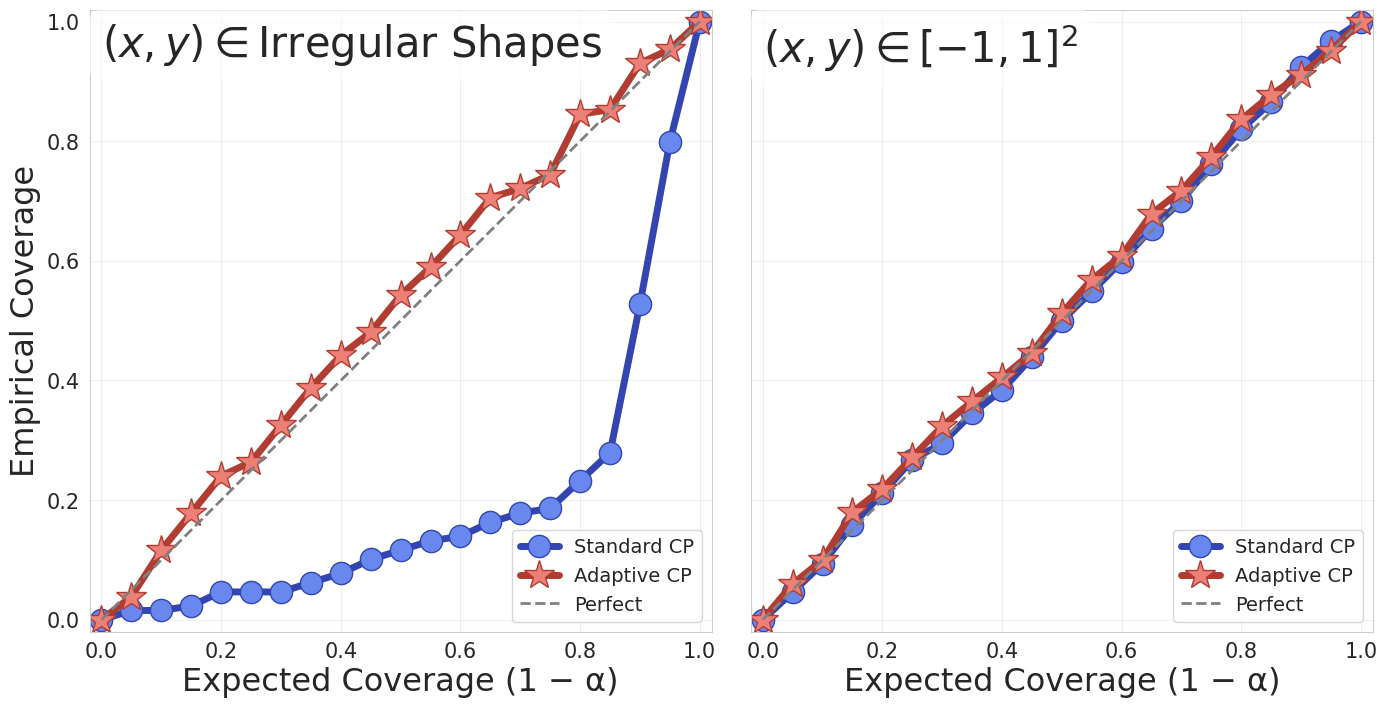

In [ ]:
def prep_coverage_data(df):
    """Prepare coverage data for plotting."""
    exp = 1.0 - df["alpha"].to_numpy()
    emp = df["coverage"].to_numpy()
    exp = np.concatenate(([0.0], exp, [1.0]))
    emp = np.concatenate(([0.0], emp, [1.0]))
    idx = np.argsort(exp)
    return exp[idx], emp[idx]

# Prepare data
exp_cp_local, emp_cp_local = prep_coverage_data(results_cp_local)
exp_acp_local, emp_acp_local = prep_coverage_data(results_acp_local)
exp_cp_global, emp_cp_global = prep_coverage_data(results_cp_global)
exp_acp_global, emp_acp_global = prep_coverage_data(results_acp_global)

# Create side-by-side plots
fig, axes = plt.subplots(1, 2, figsize=(14, 7.5))

# Left: Local (Irregular Shapes)
ax_local = axes[0]
ax_local.plot(exp_cp_local, emp_cp_local, 'o-', color="#3245b1", markerfacecolor="#6988ef",
              ms=16, lw=5, label="Standard CP")
ax_local.plot(exp_acp_local, emp_acp_local, '*-', color="#b13c32", markerfacecolor="#ed8076",
              ms=22, lw=5, label="Adaptive CP")
ax_local.plot([0, 1], [0, 1], '--', color='gray', lw=2, label='Perfect')

ax_local.text(0.02, 0.98, r"$(x,y) \in \mathrm{Irregular\ Shapes}$", transform=ax_local.transAxes,
              fontsize=30, fontweight="bold", va="top", ha="left",
              bbox=dict(facecolor="white", alpha=0.6, edgecolor="none", boxstyle="round,pad=0.3"))

ax_local.set_xlabel("Expected Coverage (1 − α)", fontsize=23)
ax_local.set_ylabel("Empirical Coverage", fontsize=23)
ax_local.margins(x=0.02, y=0.02)
ax_local.tick_params(axis='both', labelsize=15)
ax_local.legend(loc="lower right", fontsize=14)
ax_local.grid(True, alpha=0.3)
ax_local.set_aspect('equal', adjustable='box')

# Right: Global
ax_global = axes[1]
ax_global.plot(exp_cp_global, emp_cp_global, 'o-', color="#3245b1", markerfacecolor="#6988ef",
               ms=16, lw=5, label="Standard CP")
ax_global.plot(exp_acp_global, emp_acp_global, '*-', color="#b13c32", markerfacecolor="#ed8076",
               ms=22, lw=5, label="Adaptive CP")
ax_global.plot([0, 1], [0, 1], '--', color='gray', lw=2, label='Perfect')

ax_global.text(0.02, 0.98, r"$(x,y) \in [-1, 1]^2$", transform=ax_global.transAxes,
               fontsize=30, fontweight="bold", va="top", ha="left",
               bbox=dict(facecolor="white", alpha=0.6, edgecolor="none", boxstyle="round,pad=0.3"))

ax_global.set_xlabel("Expected Coverage (1 − α)", fontsize=23)
ax_global.margins(x=0.02, y=0.02)
ax_global.tick_params(axis='both', labelsize=15)
ax_global.tick_params(axis='y', left=False, labelleft=False)  # Remove y-axis ticks and labels
ax_global.legend(loc="lower right", fontsize=14)
ax_global.grid(True, alpha=0.3)
ax_global.set_aspect('equal', adjustable='box')

plt.tight_layout()
plt.show()

## Summary

### 🎯 Key Takeaways

1. **Standard CP**: Fixed-width intervals, simple and fast
2. **Adaptive CP**: Spatially varying widths, better local calibration
3. **Parallel evaluation**: Efficient testing across multiple α values
   - Each α trains independent quantile network in parallel

### 📊 Observations

- **Global**: Both achieve near-perfect calibration
- **Local (noisy region)**: Adaptive CP shows superior calibration
- **Interval widths**: Adaptive CP adapts to local uncertainty

### 📚 References

- Paper: "A Conformal Prediction Framework for Uncertainty Quantification in Physics-Informed Neural Networks" (Yu et al., 2025)
- GitHub: [RoyYu0509/local_cp](https://github.com/RoyYu0509/local_cp)